In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
energy_df = pd.read_excel(r'C:\Users\vd819\Divya\energy_dataset.xlsx')
weather_df = pd.read_excel(r"C:\Users\vd819\Divya\weather_features.xlsx")

# Merging the data 

In [3]:
# Check for columns full of zeros
zero_cols = energy_df.columns[(energy_df == 0).all()]

null_cols = energy_df.columns[energy_df.isnull().all()]

cols_to_drop = zero_cols.union(null_cols)

energy_df.drop(columns=cols_to_drop, inplace=True)

In [4]:
# Check for columns full of zeros
zero_cols = weather_df.columns[(weather_df == 0).all()]

null_cols = weather_df.columns[weather_df.isnull().all()]

cols_to_drop = zero_cols.union(null_cols)

weather_df.drop(columns=cols_to_drop, inplace=True)

In [5]:
energy_df['time'] = pd.to_datetime(energy_df['time'],utc=True)
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'],utc=True)

In [6]:
wearther_df = weather_df.drop(columns=['city_name'])

In [7]:
weather_df.head()
weather_df.shape

(178396, 17)

In [8]:
energy_df.head()
energy_df.shape

(35064, 27)

In [10]:
weather_df = weather_df.groupby('dt_iso').agg({
    'temp': 'mean',
    'temp_min': 'mean',
    'temp_max': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean',
    'rain_1h': 'mean',
    'rain_3h': 'mean',
    'snow_3h': 'mean',
    'clouds_all': 'mean',
    'weather_id': 'mean',
    'weather_main': lambda x: x.mode().iloc[0] if not x.empty else None,
    'weather_description': lambda x: x.mode().iloc[0] if not x.empty else None,
    'weather_icon': lambda x: x.mode().iloc[0] if not x.empty else None
}).reset_index()

In [11]:
print(weather_df.columns)

Index(['dt_iso', 'temp', 'temp_min', 'temp_max', 'humidity', 'wind_speed',
       'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'weather_id',
       'weather_main', 'weather_description', 'weather_icon'],
      dtype='object')


In [12]:
weather_df.shape

(35064, 14)

In [13]:
merged_data = pd.merge(energy_df, weather_df, left_on='time', right_on='dt_iso')
merged_data.head()
merged_data.shape

(35064, 41)

In [14]:
print(merged_data.columns)

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation_solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind onshore day ahead', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual', 'dt_iso',
       'temp', 'temp_min', 'temp_max', 'humidity', 'wind_speed', 'rain_1h',
       'rain_3h', 'snow_3h', 'clouds_all', 'weather_id', 'weather_main',
       'weather_description

# Exploriting analysis

In [15]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35064 entries, 0 to 35063
Data columns (total 41 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35045 non-null  float64            
 2   generation fossil brown coal/lignite         35046 non-null  float64            
 3   generation fossil coal-derived gas           35046 non-null  float64            
 4   generation fossil gas                        35046 non-null  float64            
 5   generation fossil hard coal                  35046 non-null  float64            
 6   generation fossil oil                        35045 non-null  float64            
 7   generation fossil oil shale                  35046 non-null  float64            
 8   generation fossil peat    

# Missing values imputation

In [16]:
null_counts = merged_data.isnull().sum()
print(null_counts)

time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil coal-derived gas             18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation fossil oil shale                    18
generation fossil peat                         18
generation geothermal                          18
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation marine                              19
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation_solar                               18
generation waste                               19
generation wind offshore                       18


In [17]:
merged_data = merged_data.ffill()

# outlier detection and replacement

In [18]:
def detect_and_replace_outliers(df):
    outlier_counts = {}
    
    for column in df.select_dtypes(include=[np.number]).columns:  # Select only numeric columns
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outlier_counts[column] = len(outliers)
        
        # Replace outliers with median
        median = df[column].median()
        df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), median, df[column])
    
    return df, outlier_counts

merged_data_cleaned, outlier_counts = detect_and_replace_outliers(merged_data)

print("Outlier counts for each column:")
for column, count in outlier_counts.items():
    print(f"{column}: {count}")

print("\nCleaned DataFrame (first 10 rows):")
print(merged_data_cleaned.head(10))

Outlier counts for each column:
generation biomass: 87
generation fossil brown coal/lignite: 0
generation fossil coal-derived gas: 0
generation fossil gas: 2185
generation fossil hard coal: 0
generation fossil oil: 246
generation fossil oil shale: 0
generation fossil peat: 0
generation geothermal: 0
generation hydro pumped storage consumption: 3762
generation hydro run-of-river and poundage: 0
generation hydro water reservoir: 343
generation marine: 0
generation nuclear: 79
generation other: 1267
generation other renewable: 5
generation_solar: 0
generation waste: 328
generation wind offshore: 0
generation wind onshore: 377
forecast solar day ahead: 0
forecast wind onshore day ahead: 436
total load forecast: 0
total load actual: 0
price day ahead: 841
price actual: 699
temp: 0
temp_min: 0
temp_max: 0
humidity: 0
wind_speed: 830
rain_1h: 5088
rain_3h: 1617
snow_3h: 258
clouds_all: 496
weather_id: 2011

Cleaned DataFrame (first 10 rows):
                       time  generation biomass  \


# Feature engineering 

In [19]:
#coverting the datetime to hr months and days
merged_data['time'] = pd.to_datetime(merged_data['time'], format='%Y/%m/%d %H:%M:%S',errors='coerce')
#dividing the time to month day weekday weekend
merged_data['month'] = merged_data['time'].dt.month
merged_data['day'] = merged_data['time'].dt.day
merged_data['weekday'] = merged_data['time'].dt.day_name()
merged_data['weekend'] = merged_data['time'].dt.weekday >= 5
merged_data.head(5)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon,month,day,weekday,weekend
0,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,300.0,0.0,0.0,0.0,...,0.0,0.0,800.0,clear,sky is clear,01n,12,31,Wednesday,False
1,2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,300.0,0.0,0.0,0.0,...,0.0,0.0,800.0,clear,sky is clear,01n,1,1,Thursday,False
2,2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,300.0,0.0,0.0,0.0,...,0.0,0.0,800.0,clear,sky is clear,01n,1,1,Thursday,False
3,2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,300.0,0.0,0.0,0.0,...,0.0,0.0,800.0,clear,sky is clear,01n,1,1,Thursday,False
4,2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,300.0,0.0,0.0,0.0,...,0.0,0.0,800.0,clear,sky is clear,01n,1,1,Thursday,False


In [20]:
unique_values = merged_data[['weather_main', 'month', 'day','weekday','weekend']].apply(lambda x: x.unique())
print(unique_values)

weather_main    [clear, clouds, rain, fog, thunderstorm, drizz...
month                     [12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
day             [31, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...
weekday         [Wednesday, Thursday, Friday, Saturday, Sunday...
weekend                                             [False, True]
dtype: object


In [21]:
# Get dummies for the 'weekday' column
weekday_dummies = pd.get_dummies(merged_data['weekday'])

weekday_dummies.columns = weekday_dummies.columns.str.replace('weekday_', '')

all_days = ['Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday']
for day in all_days:
    if day not in weekday_dummies.columns:
        weekday_dummies[day] = 0

weekday_dummies = weekday_dummies[all_days]

merged_data = pd.concat([merged_data, weekday_dummies], axis=1)

# Create the 'weekend' column
merged_data['weekend1'] = merged_data[['Saturday', 'Sunday']].max(axis=1)

print(merged_data['weekend1'].unique())

[0 1]


# Peak - off peak hour with total load


In [22]:
print(merged_data['total load actual'])

0        25385.0
1        24382.0
2        22734.0
3        21286.0
4        20264.0
          ...   
35059    30653.0
35060    29735.0
35061    28071.0
35062    25801.0
35063    24455.0
Name: total load actual, Length: 35064, dtype: float64


In [23]:
merged_data['hour'] = merged_data['time'].dt.hour
# caluclate the average electricity demand for each hour for all days
hourly_avg_demand = merged_data.groupby('hour')['total load actual'].mean().reset_index()
hourly_avg_demand.columns = ['hour', 'avg_hourly_demand']
merged_data = pd.merge(merged_data, hourly_avg_demand, on='hour', how='left')
merged_data.head(5)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,Wednesday,Thursday,Friday,Saturday,Sunday,Monday,Tuesday,weekend1,hour,avg_hourly_demand
0,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,300.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,23,25345.879535
1,2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,300.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,23951.776865
2,2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,300.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,23148.550308
3,2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,300.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,2,22785.642710
4,2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,300.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,3,22848.646133


In [24]:
# Create a column to classify hours as peak or off-peak based on the average hourly demand
def classify_peak_off_peak(row):
    if row['total load actual'] > row['avg_hourly_demand']:
        return 'peak'
    else:
        return 'off_peak'

In [25]:
merged_data['peak_hour'] = (merged_data['total load actual'] > merged_data['avg_hourly_demand']).astype(int)
merged_data['off_peak_hour'] = (merged_data['total load actual'] <= merged_data['avg_hourly_demand']).astype(int)


In [26]:
merged_data.head(5)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,Friday,Saturday,Sunday,Monday,Tuesday,weekend1,hour,avg_hourly_demand,peak_hour,off_peak_hour
0,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,300.0,0.0,0.0,0.0,...,0,0,0,0,0,0,23,25345.879535,1,0
1,2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,300.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,23951.776865,1,0
2,2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,300.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,23148.550308,0,1
3,2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,300.0,0.0,0.0,0.0,...,0,0,0,0,0,0,2,22785.642710,0,1
4,2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,300.0,0.0,0.0,0.0,...,0,0,0,0,0,0,3,22848.646133,0,1


# Vizualization

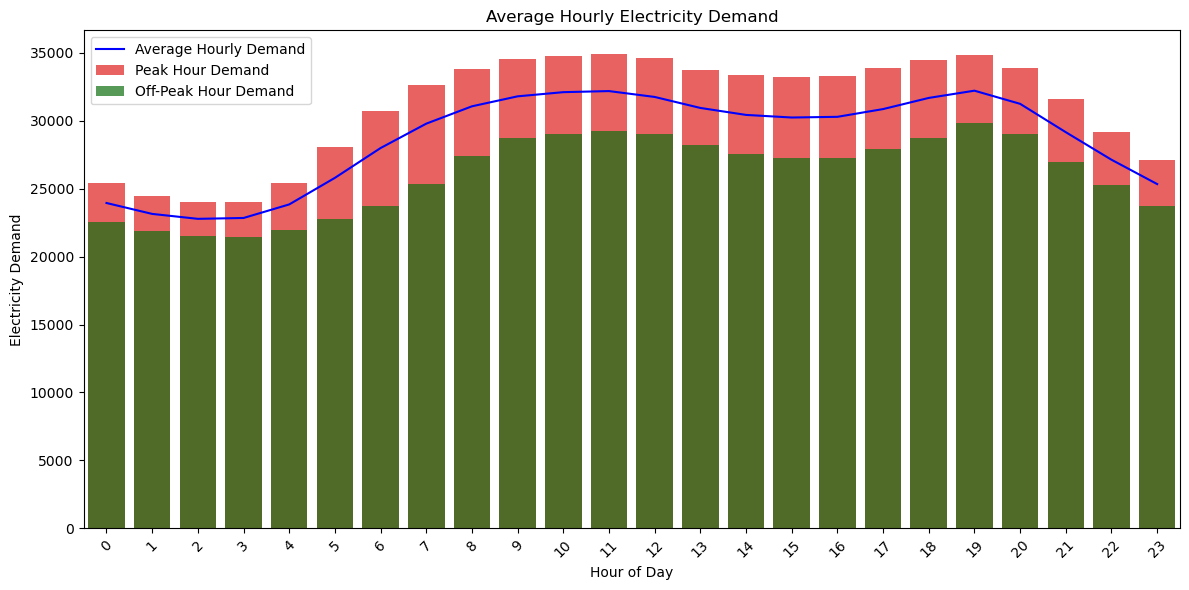

In [27]:
#PEAK AND OFF PEAK
# Calculate average hourly demand for peak and off-peak hours
hourly_avg_demand = merged_data.groupby('hour')['total load actual'].mean().reset_index()
avg_demand_peak = merged_data[merged_data['peak_hour'] == 1].groupby('hour')['total load actual'].mean().reset_index()
avg_demand_off_peak = merged_data[merged_data['peak_hour'] == 0].groupby('hour')['total load actual'].mean().reset_index()

plt.figure(figsize=(12, 6))

sns.lineplot(x='hour', y='total load actual', data=hourly_avg_demand, label='Average Hourly Demand', color='blue')

sns.barplot(x='hour', y='total load actual', data=avg_demand_peak, color='red', alpha=0.7, label='Peak Hour Demand')
sns.barplot(x='hour', y='total load actual', data=avg_demand_off_peak, color='green', alpha=0.7, label='Off-Peak Hour Demand')

plt.title('Average Hourly Electricity Demand')
plt.xlabel('Hour of Day')
plt.ylabel('Electricity Demand')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

'electricity demand ' : 'average houly demand' is only on 'peak hours' only

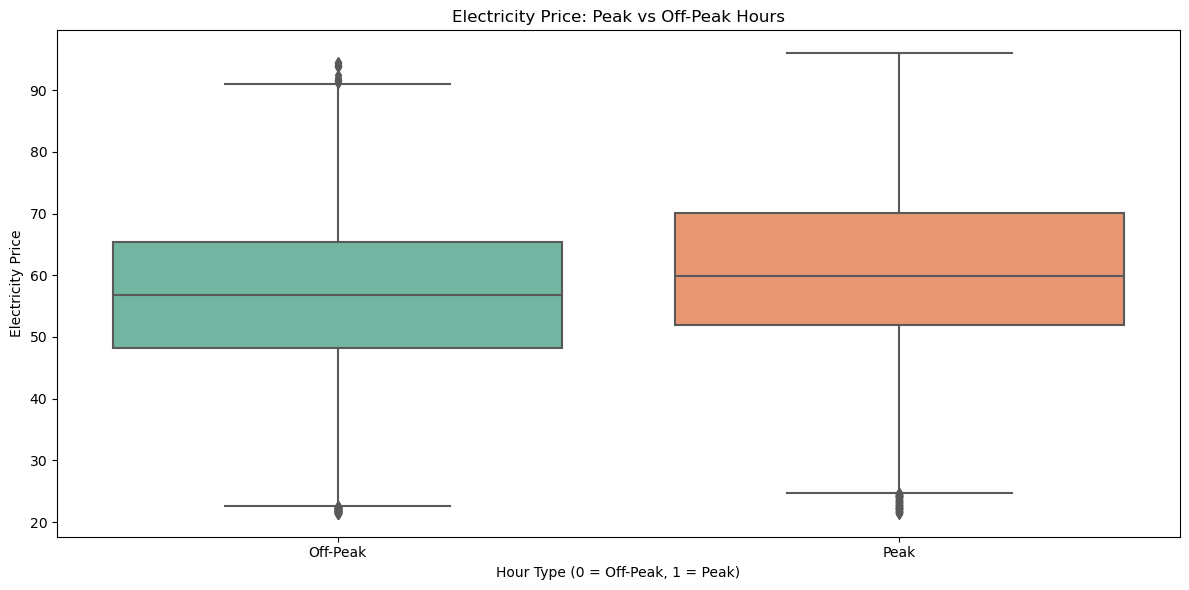

In [28]:
# Calculate average hourly price for peak and off-peak hours
avg_price_peak = merged_data[merged_data['peak_hour'] == 1].groupby('hour')['price actual'].mean().reset_index()
avg_price_off_peak = merged_data[merged_data['peak_hour'] == 0].groupby('hour')['price actual'].mean().reset_index()
plt.figure(figsize=(12, 6))
# Box plot for price during peak and off-peak periods
sns.boxplot(x='peak_hour', y='price actual', data=merged_data, palette='Set2')
plt.title('Electricity Price: Peak vs Off-Peak Hours')
plt.xlabel('Hour Type (0 = Off-Peak, 1 = Peak)')
plt.ylabel('Electricity Price')
plt.xticks([0, 1], ['Off-Peak', 'Peak'])
plt.tight_layout()
plt.show()

the 'electricity price' is high on 'peak hours' compared to the off-peak

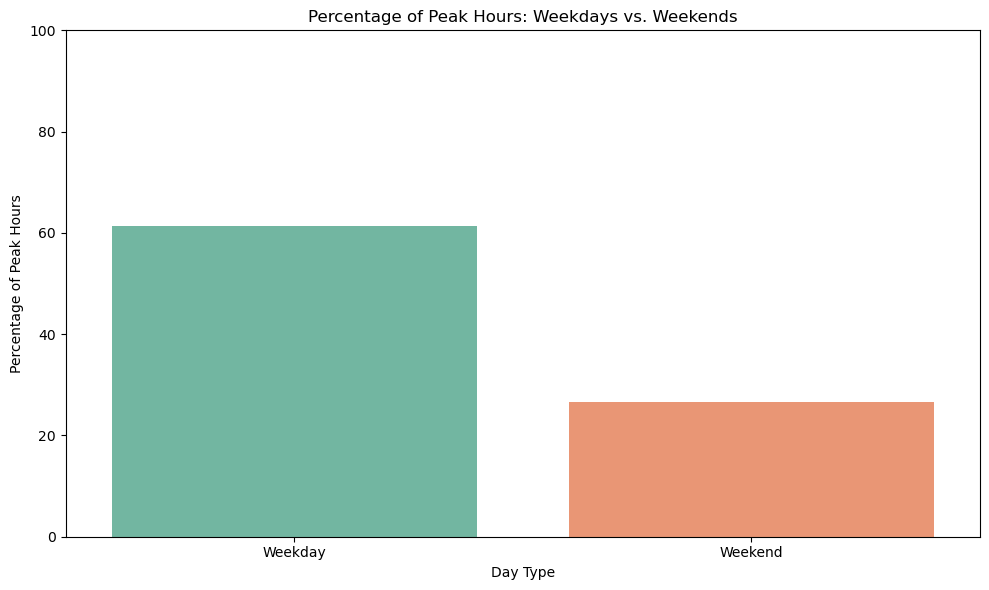

In [29]:
# Calculate percentage of peak hours for weekdays and weekends
weekday_peak_pct = merged_data[merged_data['weekend'] == False]['peak_hour'].mean() * 100
weekend_peak_pct = merged_data[merged_data['weekend'] == True]['peak_hour'].mean() * 100
plt.figure(figsize=(10, 6))
# Bar plot for weekday vs. weekend peak hours
sns.barplot(x=['Weekday', 'Weekend'], y=[weekday_peak_pct, weekend_peak_pct], palette='Set2')
plt.title('Percentage of Peak Hours: Weekdays vs. Weekends')
plt.xlabel('Day Type')
plt.ylabel('Percentage of Peak Hours')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

the bar plot says 'percentage of peak hours' is high on 'weekday' rather than weekend

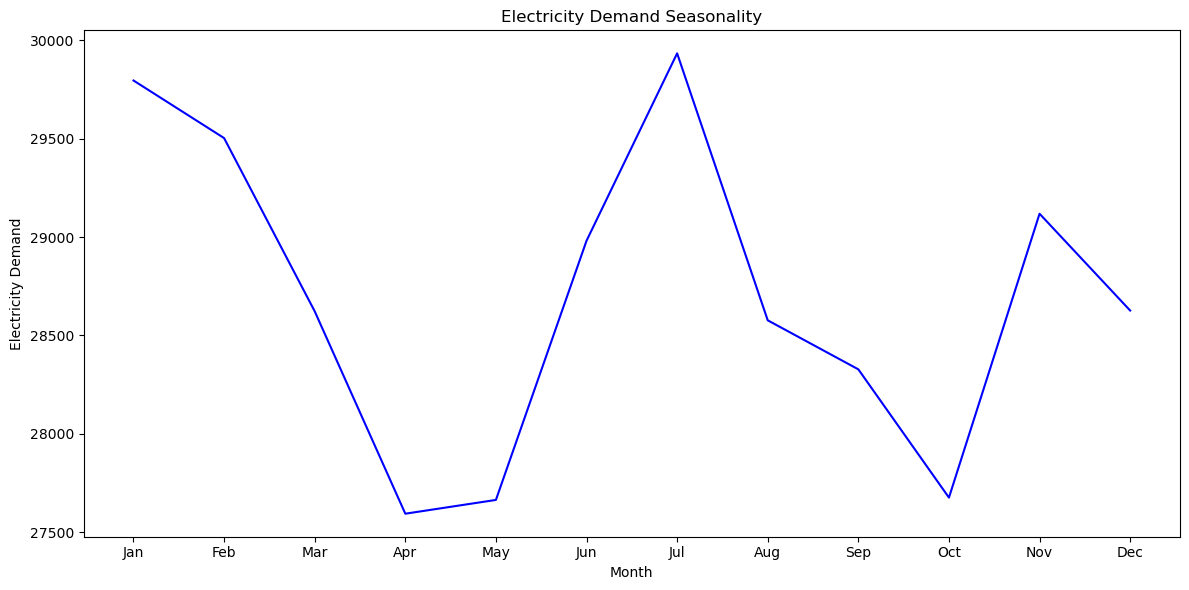

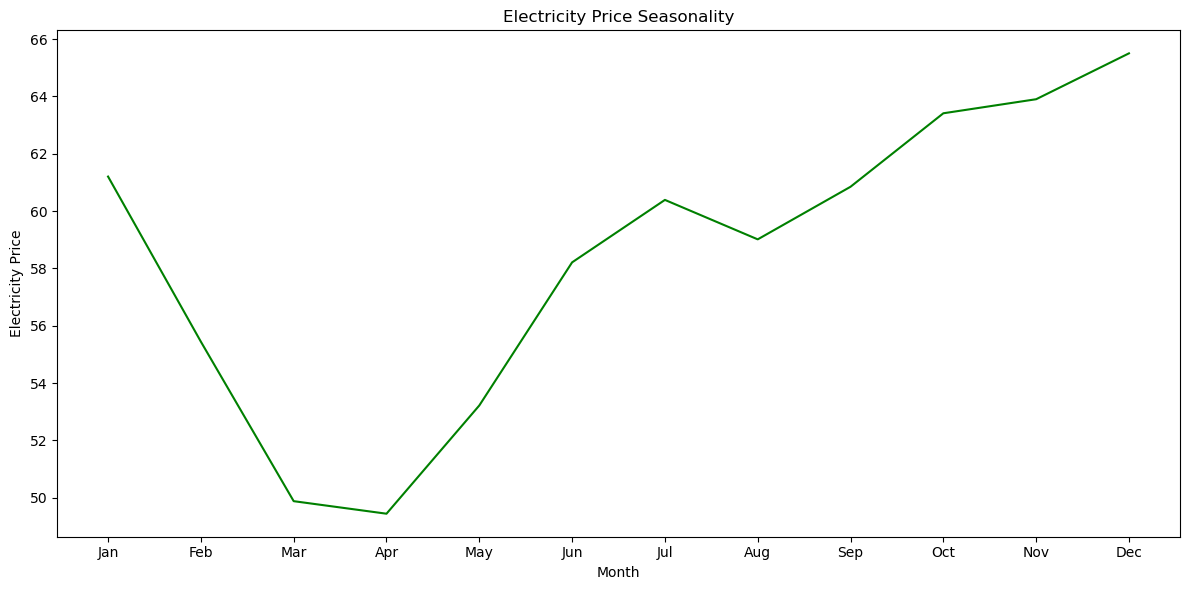

In [30]:
# Plotting demand over seasonality
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='total load actual', data=merged_data, ci=None, color='blue')
plt.title('Electricity Demand Seasonality')
plt.xlabel('Month')
plt.ylabel('Electricity Demand')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()
# Plotting price over seasonality
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='price actual', data=merged_data, ci=None, color='green')
plt.title('Electricity Price Seasonality')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

the 'electricity demand' is high on 'july' and the 'price' is increasing from 'july' to 'dec'

# Label encoding and corelation matrix

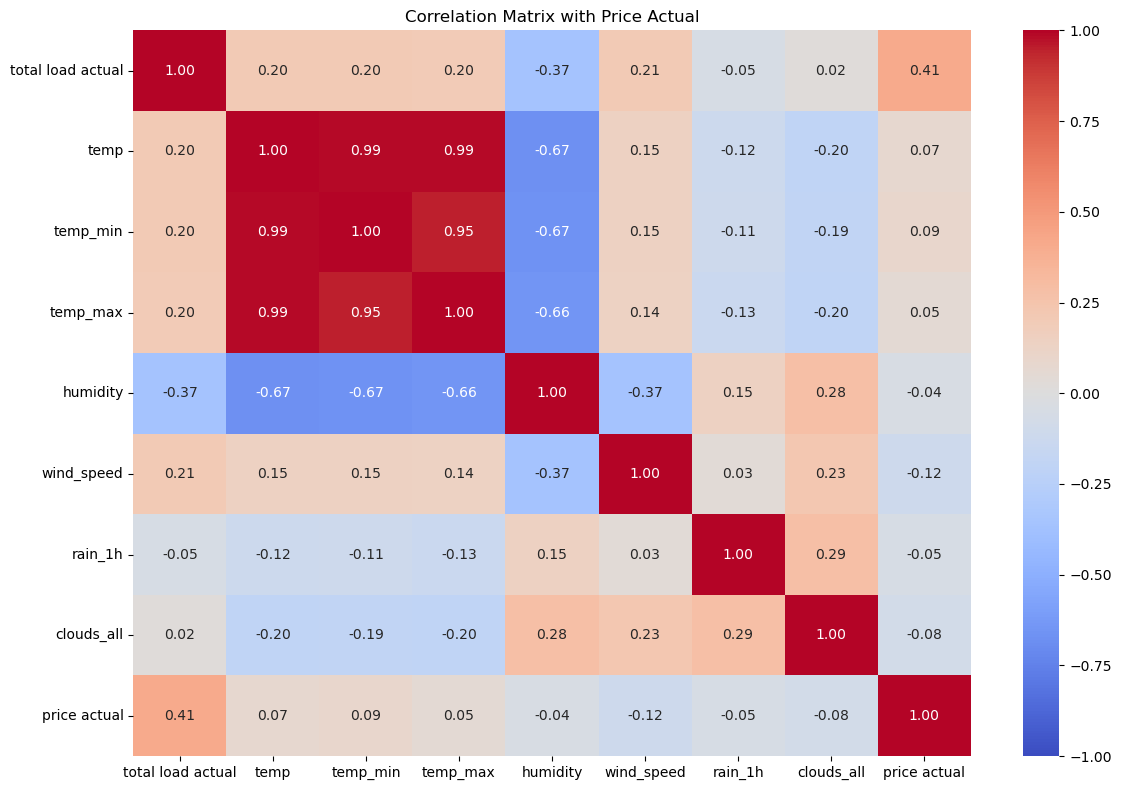

In [31]:
# Define the dependent variable (target)
dependent_variable = 'price actual'

# Define the independent variables (features)
independent_variables = [
    'total load actual', 'temp', 'temp_min', 'temp_max', 'humidity', 
    'wind_speed', 'rain_1h', 'clouds_all'
]

# Selecting the relevant columns
data_for_analysis = merged_data[independent_variables + [dependent_variable]]

# Calculate the correlation matrix
correlation_matrix = data_for_analysis.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix with Price Actual')
plt.tight_layout()

# Show plot
plt.show()

correlation: load_actual: 'temp','temp_min','temp_max' and 
price_actual : 'total load actual','temp','temp_min','temp_max' have the strong relation

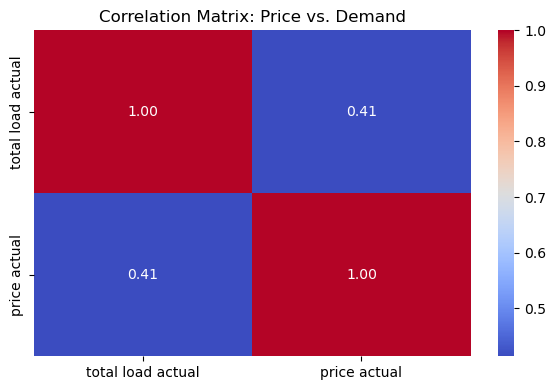

In [32]:
#correlation matrix for prime and demand
correlation_matrix = merged_data[['total load actual', 'price actual']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Price vs. Demand')
plt.tight_layout()
plt.show()

0.41 is the correlation betweeen 'price actual' and 'total load actual'

# Vizualization for price

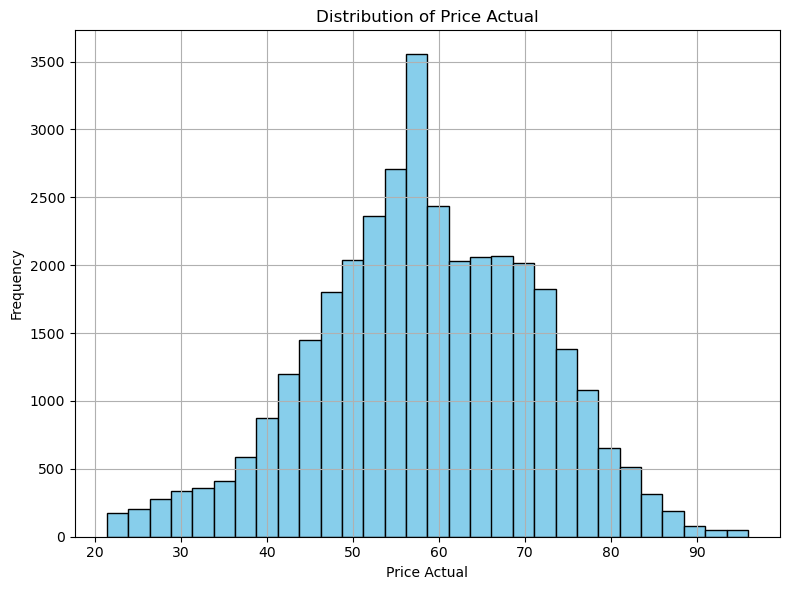

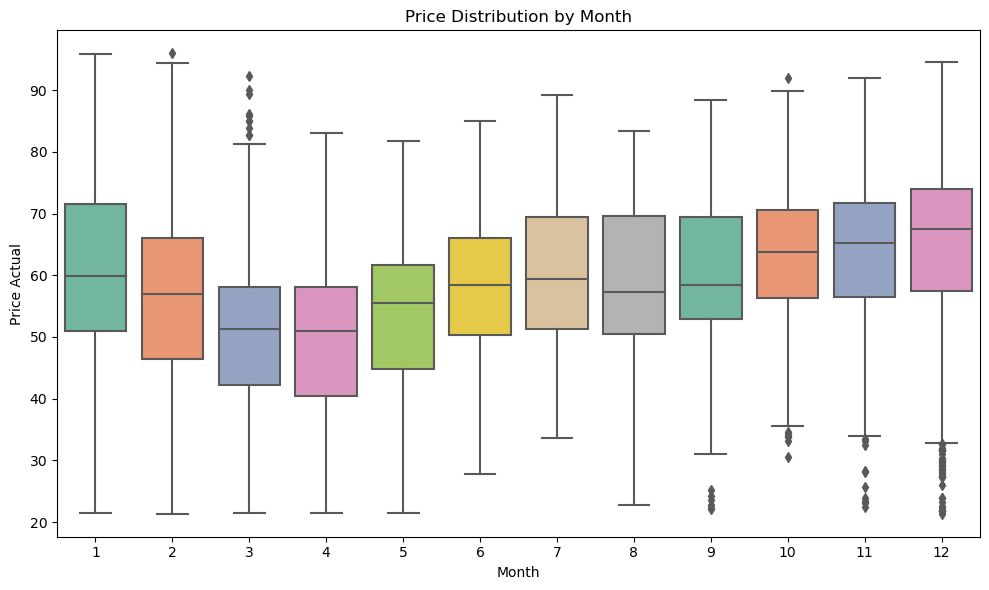

In [33]:
# Plotting histogram of price actual
plt.figure(figsize=(8, 6))
plt.hist(merged_data['price actual'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Price Actual')
plt.xlabel('Price Actual')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()
# Box Plot for Price Distribution Across Different Categories
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='price actual', data=merged_data, palette='Set2')
plt.title('Price Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Price Actual')
plt.tight_layout()
plt.show()

the 'price actual' is high on 'july' [frequency]
the 'price actual ' is increasing from june to december and decreased on feb to may

# Linear regression model

In [34]:
merged_data['year'] = merged_data['dt_iso'].dt.year
merged_data['month'] = merged_data['dt_iso'].dt.month
merged_data['day'] = merged_data['dt_iso'].dt.day
merged_data['hour'] = merged_data['dt_iso'].dt.hour

In [35]:
# Extract useful datetime features
merged_data['dt_iso'] = pd.to_datetime(merged_data['dt_iso'])
merged_data['hour'] = merged_data['dt_iso'].dt.hour
merged_data['day'] = merged_data['dt_iso'].dt.day
merged_data['month'] = merged_data['dt_iso'].dt.month
merged_data['year'] = merged_data['dt_iso'].dt.year
merged_data['weekday'] = merged_data['dt_iso'].dt.weekday
merged_data['weekend'] = (merged_data['weekday'] >= 5).astype(int)


In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Drop any rows with missing values for simplicity
merged_data = merged_data.dropna()

# Extract useful datetime features
merged_data['dt_iso'] = pd.to_datetime(merged_data['dt_iso'])
merged_data['hour'] = merged_data['dt_iso'].dt.hour
merged_data['day'] = merged_data['dt_iso'].dt.day
merged_data['month'] = merged_data['dt_iso'].dt.month
merged_data['year'] = merged_data['dt_iso'].dt.year
merged_data['weekday'] = merged_data['dt_iso'].dt.weekday
merged_data['weekend'] = (merged_data['weekday'] >= 5).astype(int)

# Ensure 'weather_main', 'weather_description', 'weather_icon' exist in the DataFrame
if all(col in merged_data.columns for col in ['weather_main', 'weather_description', 'weather_icon']):
    # One-hot encode datetime and categorical features
    datetime_features = ['hour', 'day', 'month', 'year', 'weekday', 'weekend']
    categorical_features = ['weather_main', 'weather_description', 'weather_icon']
    merged_data = pd.get_dummies(merged_data, columns=datetime_features + categorical_features)
else:
    print("Some of the specified categorical columns do not exist in the DataFrame.")

# Define the features to exclude 'dt_iso'
load_features = [col for col in merged_data.columns if col not in ['time', 'total load forecast', 'total load actual', 'dt_iso']]
price_features = [col for col in merged_data.columns if col not in ['time', 'total load forecast', 'price actual', 'price day ahead', 'dt_iso']]

# Define target variables
target_price = 'price actual'
target_load = 'total load actual'

# Split the data into training, validation, and test sets for price prediction
X_price_full = merged_data[price_features]
y_price_full = merged_data[target_price]

X_train_price_set, X_temp_price_set, y_train_price_set, y_temp_price_set = train_test_split(
    X_price_full, y_price_full, test_size=0.4, random_state=42)

X_val_price_set, X_test_price_set, y_val_price_set, y_test_price_set = train_test_split(
    X_temp_price_set, y_temp_price_set, test_size=0.5, random_state=42)

# Split the data into training, validation, and test sets for load prediction
X_load_full = merged_data[load_features]
y_load_full = merged_data[target_load]

X_train_load_set, X_temp_load_set, y_train_load_set, y_temp_load_set = train_test_split(
    X_load_full, y_load_full, test_size=0.4, random_state=42)

X_val_load_set, X_test_load_set, y_val_load_set, y_test_load_set = train_test_split(
    X_temp_load_set, y_temp_load_set, test_size=0.5, random_state=42)

# Scale the features
scaler_price = StandardScaler()
X_train_price_scaled = scaler_price.fit_transform(X_train_price_set)
X_val_price_scaled = scaler_price.transform(X_val_price_set)
X_test_price_scaled = scaler_price.transform(X_test_price_set)

scaler_load = StandardScaler()
X_train_load_scaled = scaler_load.fit_transform(X_train_load_set)
X_val_load_scaled = scaler_load.transform(X_val_load_set)
X_test_load_scaled = scaler_load.transform(X_test_load_set)

# Initialize and train the linear regression models with regularization
model_price = Ridge()  # Using Ridge regression for price prediction
model_price.fit(X_train_price_scaled, y_train_price_set)

model_load = Ridge()  # Using Ridge regression for load prediction
model_load.fit(X_train_load_scaled, y_train_load_set)

# Predict on validation and test sets
y_val_price_predicted = model_price.predict(X_val_price_scaled)
y_test_price_predicted = model_price.predict(X_test_price_scaled)

y_val_load_predicted = model_load.predict(X_val_load_scaled)
y_test_load_predicted = model_load.predict(X_test_load_scaled)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, n, k):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    return mae, rmse, mape, r2, adj_r2

# Calculate metrics for price prediction
n_val_price = X_val_price_scaled.shape[0]
k_price = X_val_price_scaled.shape[1]

metrics_val_price = calculate_metrics(y_val_price_set, y_val_price_predicted, n_val_price, k_price)
metrics_test_price = calculate_metrics(y_test_price_set, y_test_price_predicted, X_test_price_scaled.shape[0], X_test_price_scaled.shape[1])

# Calculate metrics for load prediction
n_val_load = X_val_load_scaled.shape[0]
k_load = X_val_load_scaled.shape[1]

metrics_val_load = calculate_metrics(y_val_load_set, y_val_load_predicted, n_val_load, k_load)
metrics_test_load = calculate_metrics(y_test_load_set, y_test_load_predicted, X_test_load_scaled.shape[0], X_test_load_scaled.shape[1])

print("Price Actual - Test Set:")
print(f"MAE: {metrics_test_price[0]:.2f}")
print(f"RMSE: {metrics_test_price[1]:.2f}")
print(f"MAPE: {metrics_test_price[2]:.2f}%")
print(f"R^2: {metrics_test_price[3]:.2f}")
print(f"Adjusted R^2: {metrics_test_price[4]:.2f}\n")

print("Total Load Actual - Test Set:")
print(f"MAE: {metrics_test_load[0]:.2f}")
print(f"RMSE: {metrics_test_load[1]:.2f}")
print(f"MAPE: {metrics_test_load[2]:.2f}%")
print(f"R^2: {metrics_test_load[3]:.2f}")
print(f"Adjusted R^2: {metrics_test_load[4]:.2f}\n")


Price Actual - Test Set:
MAE: 6.18
RMSE: 8.07
MAPE: 11.60%
R^2: 0.61
Adjusted R^2: 0.60

Total Load Actual - Test Set:
MAE: 1050.88
RMSE: 1363.56
MAPE: 3.76%
R^2: 0.91
Adjusted R^2: 0.91



# Random Forest 


In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return (abs((y_true - y_pred) / y_true)).mean() * 100

# Function to calculate adjusted R^2
def adjusted_r2_score(r2, n, p):
    return 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

# Sample the data to reduce size (e.g., 50% of the data)
sampled_data = merged_data.sample(frac=0.5, random_state=42)

# Define the features
features_for_price = [col for col in merged_data.columns if col not in ['time', 'total load forecast', 'price actual', 'price day ahead', 'dt_iso', 'weather_main', 'weather_id', 'weather_description', 'weather_icon']]
features_for_load = [col for col in merged_data.columns if col not in ['time', 'total load forecast', 'total load actual', 'dt_iso', 'weather_main', 'weather_id', 'weather_description', 'weather_icon']]

# Split features and target variables for price and load prediction
X_price_sampled = sampled_data[features_for_price]
y_price_sampled = sampled_data['price actual']
X_load_sampled = sampled_data[features_for_load]
y_load_sampled = sampled_data['total load actual']

# Split data into training and test sets for price prediction
X_train_price_split, X_test_price_split, y_train_price_split, y_test_price_split = train_test_split(X_price_sampled, y_price_sampled, test_size=0.2, random_state=42)

# Split data into training and test sets for load prediction
X_train_load_split, X_test_load_split, y_train_load_split, y_test_load_split = train_test_split(X_load_sampled, y_load_sampled, test_size=0.2, random_state=42)

# Initialize and train Random Forest models
model_price_rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
model_load_rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)

model_price_rf.fit(X_train_price_split, y_train_price_split)
model_load_rf.fit(X_train_load_split, y_train_load_split)

# Predict on test set for price and load
y_pred_price_split = model_price_rf.predict(X_test_price_split)
y_pred_load_split = model_load_rf.predict(X_test_load_split)

# Function to calculate and print metrics
def print_metrics(y_true, y_pred, target_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    n = len(y_true)
    p = len(y_true)  # Use the number of features for adjusted R²
    adjusted_r2 = adjusted_r2_score(r2, n, p)

    print(f"{target_name} - Random Forest:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R^2: {r2:.2f}")
    print(f"Adjusted R^2: {adjusted_r2:.2f}")
    print(f"MAPE: {mape:.2f}%\n")

# Print metrics for price prediction
print_metrics(y_test_price_split, y_pred_price_split, "Price Actual")

# Print metrics for load prediction
print_metrics(y_test_load_split, y_pred_load_split, "Total Load Actual")


Price Actual - Random Forest:
MAE: 4.55
RMSE: 6.21
R^2: 0.77
Adjusted R^2: 797.53
MAPE: 8.81%

Total Load Actual - Random Forest:
MAE: 935.04
RMSE: 1209.91
R^2: 0.93
Adjusted R^2: 252.47
MAPE: 3.32%



# Random Forest with parameter tuning

In [38]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Function to calculate adjusted R-squared
def adjusted_r2(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Sample the data to reduce size (e.g., 10% of the data)
sampled_data = merged_data.sample(frac=0.1, random_state=42)

# Define features for price and load predictions
features_for_price = ['temp', 'temp_min', 'temp_max']  # Define your features here
features_for_load = ['temp', 'temp_min', 'temp_max']    # Define your features here

# Split the data into features and target for price and load
X_price_data = sampled_data[features_for_price]
y_price_data = sampled_data['price actual']
X_load_data = sampled_data[features_for_load]
y_load_data = sampled_data['total load actual']

# Split data into training and test sets for price prediction
X_train_price_final, X_test_price_final, y_train_price_final, y_test_price_final = train_test_split(X_price_data, y_price_data, test_size=0.2, random_state=42)

# Split data into training and test sets for load prediction
X_train_load_final, X_test_load_final, y_train_load_final, y_test_load_final = train_test_split(X_load_data, y_load_data, test_size=0.2, random_state=42)

# Standardize the features for price prediction
scaler_price = StandardScaler()
X_train_price_scaled_final = scaler_price.fit_transform(X_train_price_final)
X_test_price_scaled_final = scaler_price.transform(X_test_price_final)

# Standardize the features for load prediction
scaler_load = StandardScaler()
X_train_load_scaled_final = scaler_load.fit_transform(X_train_load_final)
X_test_load_scaled_final = scaler_load.transform(X_test_load_final)

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [5],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True]
}

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Function for GridSearchCV and model fitting
def grid_search_fit(X_train, y_train, param_grid):
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Train models and get best parameters for price prediction
best_rf_model_price_final, best_rf_params_price_final = grid_search_fit(X_train_price_scaled_final, y_train_price_final, param_grid_rf)

# Predict and calculate metrics for price prediction
y_pred_price_rf_final = best_rf_model_price_final.predict(X_test_price_scaled_final)
mae_price_rf_final = mean_absolute_error(y_test_price_final, y_pred_price_rf_final)
rmse_price_rf_final = np.sqrt(mean_squared_error(y_test_price_final, y_pred_price_rf_final))
mape_price_rf_final = mean_absolute_percentage_error(y_test_price_final, y_pred_price_rf_final)
r2_price_rf_final = r2_score(y_test_price_final, y_pred_price_rf_final)
adjusted_r2_price_rf_final = adjusted_r2(r2_price_rf_final, X_test_price_final.shape[0], X_test_price_final.shape[1])

print("Random Forest - Price Prediction:")
print(f"Best Parameters: {best_rf_params_price_final}")
print(f"MAE: {mae_price_rf_final:.2f}")
print(f"RMSE: {rmse_price_rf_final:.2f}")
print(f"MAPE: {mape_price_rf_final:.2f}%")
print(f"R^2: {r2_price_rf_final:.2f}")
print(f"Adjusted R^2: {adjusted_r2_price_rf_final:.2f}")

# Train models and get best parameters for load prediction
best_rf_model_load_final, best_rf_params_load_final = grid_search_fit(X_train_load_scaled_final, y_train_load_final, param_grid_rf)

# Predict and calculate metrics for load prediction
y_pred_load_rf_final = best_rf_model_load_final.predict(X_test_load_scaled_final)
mae_load_rf_final = mean_absolute_error(y_test_load_final, y_pred_load_rf_final)
rmse_load_rf_final = np.sqrt(mean_squared_error(y_test_load_final, y_pred_load_rf_final))
mape_load_rf_final = mean_absolute_percentage_error(y_test_load_final, y_pred_load_rf_final)
r2_load_rf_final = r2_score(y_test_load_final, y_pred_load_rf_final)
adjusted_r2_load_rf_final = adjusted_r2(r2_load_rf_final, X_test_load_final.shape[0], X_test_load_final.shape[1])

print("Random Forest - Load Prediction:")
print(f"Best Parameters: {best_rf_params_load_final}")
print(f"MAE: {mae_load_rf_final:.2f}")
print(f"RMSE: {rmse_load_rf_final:.2f}")
print(f"MAPE: {mape_load_rf_final:.2f}%")
print(f"R^2: {r2_load_rf_final:.2f}")
print(f"Adjusted R^2: {adjusted_r2_load_rf_final:.2f}")


Random Forest - Price Prediction:
Best Parameters: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
MAE: 9.91
RMSE: 12.26
MAPE: 19.37%
R^2: 0.05
Adjusted R^2: 0.04
Random Forest - Load Prediction:
Best Parameters: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
MAE: 3638.82
RMSE: 4313.85
MAPE: 13.00%
R^2: 0.08
Adjusted R^2: 0.07


# GradientBoostingRegressor

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return (abs((y_true - y_pred) / y_true)).mean() * 100

# Sample the data to reduce size (e.g., 50% of the data)
sampled_data_gb = merged_data.sample(frac=0.5, random_state=42)

# Define the features for simplicity
features_for_price_gb = [col for col in merged_data.columns if col not in ['time', 'total load forecast', 'price actual', 'price day ahead', 'dt_iso','weather_main','weather_id','weather_description','weather_icon']]
features_for_load_gb = [col for col in merged_data.columns if col not in ['time', 'total load forecast', 'total load actual', 'dt_iso','weather_main','weather_id','weather_description','weather_icon']]

# Split features and target variables for price prediction
X_price_gb = sampled_data_gb[features_for_price_gb]
y_price_gb = sampled_data_gb['price actual']

# Split features and target variables for load prediction
X_load_gb = sampled_data_gb[features_for_load_gb]
y_load_gb = sampled_data_gb['total load actual']

# Split data into training and test sets for price prediction
X_train_price_gb, X_test_price_gb, y_train_price_gb, y_test_price_gb = train_test_split(
    X_price_gb, y_price_gb, test_size=0.2, random_state=42)

# Split data into training and test sets for load prediction
X_train_load_gb, X_test_load_gb, y_train_load_gb, y_test_load_gb = train_test_split(
    X_load_gb, y_load_gb, test_size=0.2, random_state=42)

# Initialize and train Gradient Boosting models with unique variable names
model_price_gb_final = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
model_load_gb_final = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)

model_price_gb_final.fit(X_train_price_gb, y_train_price_gb)
model_load_gb_final.fit(X_train_load_gb, y_train_load_gb)

# Predict on test set
y_pred_price_gb_final = model_price_gb_final.predict(X_test_price_gb)
y_pred_load_gb_final = model_load_gb_final.predict(X_test_load_gb)

# Calculate metrics for price prediction
mae_price_gb_final = mean_absolute_error(y_test_price_gb, y_pred_price_gb_final)
rmse_price_gb_final = mean_squared_error(y_test_price_gb, y_pred_price_gb_final, squared=False)
r2_price_gb_final = r2_score(y_test_price_gb, y_pred_price_gb_final)
mape_price_gb_final = mean_absolute_percentage_error(y_test_price_gb, y_pred_price_gb_final)

# Calculate metrics for load prediction
mae_load_gb_final = mean_absolute_error(y_test_load_gb, y_pred_load_gb_final)
rmse_load_gb_final = mean_squared_error(y_test_load_gb, y_pred_load_gb_final, squared=False)
r2_load_gb_final = r2_score(y_test_load_gb, y_pred_load_gb_final)
mape_load_gb_final = mean_absolute_percentage_error(y_test_load_gb, y_pred_load_gb_final)

# Calculate adjusted R^2 for price prediction
n_price_gb = len(y_test_price_gb)
k_price_gb = X_test_price_gb.shape[1]
adj_r2_price_gb_final = 1 - ((1 - r2_price_gb_final) * (n_price_gb - 1)) / (n_price_gb - k_price_gb - 1)

# Calculate adjusted R^2 for load prediction
n_load_gb = len(y_test_load_gb)
k_load_gb = X_test_load_gb.shape[1]
adj_r2_load_gb_final = 1 - ((1 - r2_load_gb_final) * (n_load_gb - 1)) / (n_load_gb - k_load_gb - 1)

# Print metrics for price prediction
print("Price Actual - Gradient Boosting:")
print(f"MAE: {mae_price_gb_final:.2f}")
print(f"RMSE: {rmse_price_gb_final:.2f}")
print(f"R^2: {r2_price_gb_final:.2f}")
print(f"Adjusted R^2: {adj_r2_price_gb_final:.2f}")
print(f"MAPE: {mape_price_gb_final:.2f}%\n")

# Print metrics for load prediction
print("Total Load Actual - Gradient Boosting:")
print(f"MAE: {mae_load_gb_final:.2f}")
print(f"RMSE: {rmse_load_gb_final:.2f}")
print(f"R^2: {r2_load_gb_final:.2f}")
print(f"Adjusted R^2: {adj_r2_load_gb_final:.2f}")
print(f"MAPE: {mape_load_gb_final:.2f}%\n")


Price Actual - Gradient Boosting:
MAE: 5.08
RMSE: 6.87
R^2: 0.72
Adjusted R^2: 0.71
MAPE: 9.78%

Total Load Actual - Gradient Boosting:
MAE: 946.05
RMSE: 1201.30
R^2: 0.93
Adjusted R^2: 0.93
MAPE: 3.34%



# GradientBoosting with parameter tuning


In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Function to calculate adjusted R-squared
def adjusted_r2(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Sample the data to reduce size (e.g., 10% of the data)
sampled_data_gbt = merged_data.sample(frac=0.1, random_state=42)

# Define the features for simplicity
features_for_price_gbt = [col for col in merged_data.columns if col not in ['time', 'total load forecast', 'price actual', 'price day ahead', 'dt_iso','weather_main','weather_id','weather_description','weather_icon']]
features_for_load_gbt = [col for col in merged_data.columns if col not in ['time', 'total load forecast', 'total load actual', 'dt_iso','weather_main','weather_id','weather_description','weather_icon']]

# Split the data into features and target for price and load
X_price_gbt = sampled_data_gbt[features_for_price_gbt]
y_price_gbt = sampled_data_gbt['price actual']

X_load_gbt = sampled_data_gbt[features_for_load_gbt]
y_load_gbt = sampled_data_gbt['total load actual']

# Split data into training and test sets for price prediction
X_train_price_gbt, X_test_price_gbt, y_train_price_gbt, y_test_price_gbt = train_test_split(X_price_gbt, y_price_gbt, test_size=0.2, random_state=42)

# Split data into training and test sets for load prediction
X_train_load_gbt, X_test_load_gbt, y_train_load_gbt, y_test_load_gbt = train_test_split(X_load_gbt, y_load_gbt, test_size=0.2, random_state=42)

# Standardize the features
scaler_gbt = StandardScaler()
X_train_price_gbt_scaled = scaler_gbt.fit_transform(X_train_price_gbt)
X_test_price_gbt_scaled = scaler_gbt.transform(X_test_price_gbt)
X_train_load_gbt_scaled = scaler_gbt.fit_transform(X_train_load_gbt)
X_test_load_gbt_scaled = scaler_gbt.transform(X_test_load_gbt)

# Define the parameter grid for Gradient Boosting
param_grid_gbt = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
}

# Initialize the Gradient Boosting model
gb_model_gbt = GradientBoostingRegressor(random_state=42)

# Use GridSearchCV to find the best parameters for load prediction
grid_search_gbt_load = GridSearchCV(estimator=gb_model_gbt, param_grid=param_grid_gbt, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search_gbt_load.fit(X_train_load_gbt, y_train_load_gbt)

# Best parameters and model for load prediction
best_gb_params_gbt = grid_search_gbt_load.best_params_
best_gb_model_gbt = grid_search_gbt_load.best_estimator_

# Predict on test set for load
y_pred_load_gbt = best_gb_model_gbt.predict(X_test_load_gbt)

# Calculate metrics for Gradient Boosting - Load Prediction
mae_load_gbt = mean_absolute_error(y_test_load_gbt, y_pred_load_gbt)
rmse_load_gbt = np.sqrt(mean_squared_error(y_test_load_gbt, y_pred_load_gbt))
r2_load_gbt = r2_score(y_test_load_gbt, y_pred_load_gbt)
mape_load_gbt = np.mean(np.abs((y_test_load_gbt - y_pred_load_gbt) / y_test_load_gbt)) * 100

# Calculate adjusted R^2 for load prediction
n_load_gbt = len(y_test_load_gbt)
k_load_gbt = X_test_load_gbt.shape[1]
adj_r2_load_gbt = adjusted_r2(r2_load_gbt, n_load_gbt, k_load_gbt)

# Print metrics for load prediction
print("Gradient Boosting - Load Prediction:")
print(f"Best Parameters: {best_gb_params_gbt}")
print(f"MAE: {mae_load_gbt:.2f}")
print(f"RMSE: {rmse_load_gbt:.2f}")
print(f"R^2: {r2_load_gbt:.2f}")
print(f"Adjusted R^2: {adj_r2_load_gbt:.2f}")
print(f"MAPE: {mape_load_gbt:.2f}%\n")

# Use GridSearchCV to find the best parameters for price prediction
grid_search_gbt_price = GridSearchCV(estimator=gb_model_gbt, param_grid=param_grid_gbt, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search_gbt_price.fit(X_train_price_gbt_scaled, y_train_price_gbt)

# Best parameters and model for price prediction
best_gb_params_price_gbt = grid_search_gbt_price.best_params_
best_gb_model_price_gbt = grid_search_gbt_price.best_estimator_

# Predict on test set for price
y_pred_price_gbt = best_gb_model_price_gbt.predict(X_test_price_gbt_scaled)

# Calculate metrics for Gradient Boosting - Price Prediction
mae_price_gbt = mean_absolute_error(y_test_price_gbt, y_pred_price_gbt)
rmse_price_gbt = np.sqrt(mean_squared_error(y_test_price_gbt, y_pred_price_gbt))
r2_price_gbt = r2_score(y_test_price_gbt, y_pred_price_gbt)
adjusted_r2_price_gbt = adjusted_r2(r2_price_gbt, X_test_price_gbt.shape[0], X_test_price_gbt.shape[1])
mape_price_gbt = np.mean(np.abs((y_test_price_gbt - y_pred_price_gbt) / y_test_price_gbt)) * 100

# Print metrics for price prediction
print("Gradient Boosting - Price Prediction:")
print(f"Best Parameters: {best_gb_params_price_gbt}")
print(f"MAE: {mae_price_gbt:.2f}")
print(f"RMSE: {rmse_price_gbt:.2f}")
print(f"R^2: {r2_price_gbt:.2f}")
print(f"Adjusted R^2: {adjusted_r2_price_gbt:.2f}")
print(f"MAPE: {mape_price_gbt:.2f}%\n")


Gradient Boosting - Load Prediction:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
MAE: 810.40
RMSE: 1051.26
R^2: 0.95
Adjusted R^2: 0.93
MAPE: 2.83%

Gradient Boosting - Price Prediction:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
MAE: 4.22
RMSE: 5.76
R^2: 0.79
Adjusted R^2: 0.72
MAPE: 8.11%



# LSTM Model

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Drop any rows with missing values for simplicity
merged_data = merged_data.dropna()

# Extract useful datetime features
merged_data['dt_iso'] = pd.to_datetime(merged_data['dt_iso'])
merged_data['hour'] = merged_data['dt_iso'].dt.hour
merged_data['day'] = merged_data['dt_iso'].dt.day
merged_data['month'] = merged_data['dt_iso'].dt.month
merged_data['year'] = merged_data['dt_iso'].dt.year
merged_data['weekday'] = merged_data['dt_iso'].dt.weekday
merged_data['weekend'] = (merged_data['weekday'] >= 5).astype(int)

# Check for existence of categorical columns
weather_columns = ['weather_main', 'weather_description', 'weather_icon']
existing_weather_columns = [col for col in weather_columns if col in merged_data.columns]

# One-hot encode datetime and existing categorical features
datetime_features = ['hour', 'day', 'month', 'year', 'weekday', 'weekend']
merged_data = pd.get_dummies(merged_data, columns=datetime_features + existing_weather_columns)

# Define features and target for price prediction
price_features = [col for col in merged_data.columns if col not in ['time', 'total load forecast', 'price actual', 'price day ahead', 'dt_iso']]
target_price = 'price actual'

# Split data for price prediction
X_price = merged_data[price_features]
y_price = merged_data[target_price]
X_train_price, X_temp_price, y_train_price, y_temp_price = train_test_split(X_price, y_price, test_size=0.4, random_state=42)
X_val_price, X_test_price, y_val_price, y_test_price = train_test_split(X_temp_price, y_temp_price, test_size=0.5, random_state=42)

# Scale features for price prediction
scaler_price = StandardScaler()
X_train_price = scaler_price.fit_transform(X_train_price)
X_val_price = scaler_price.transform(X_val_price)
X_test_price = scaler_price.transform(X_test_price)

# Reshape data for LSTM
X_train_price = X_train_price.reshape((X_train_price.shape[0], 1, X_train_price.shape[1]))
X_val_price = X_val_price.reshape((X_val_price.shape[0], 1, X_val_price.shape[1]))
X_test_price = X_test_price.reshape((X_test_price.shape[0], 1, X_test_price.shape[1]))

# Build LSTM model for price prediction
model_price = Sequential()
model_price.add(LSTM(100, activation='relu', input_shape=(X_train_price.shape[1], X_train_price.shape[2]), return_sequences=True))
model_price.add(Dropout(0.2))
model_price.add(LSTM(50, activation='relu'))
model_price.add(Dropout(0.2))
model_price.add(Dense(1))

# Compile and fit the price model
optimizer_price = Adam(learning_rate=0.001)
model_price.compile(optimizer=optimizer_price, loss='mse')
early_stopping_price = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_price.fit(X_train_price, y_train_price, epochs=10, batch_size=32, validation_data=(X_val_price, y_val_price), callbacks=[early_stopping_price], verbose=1)

# Predict on validation and test sets for price
y_val_price_pred = model_price.predict(X_val_price).flatten()
y_test_price_pred = model_price.predict(X_test_price).flatten()

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, mape, r2

# Function to calculate adjusted R²
def adjusted_r2_score(y_true, y_pred, num_features):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)  # number of observations
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - num_features - 1)
    return adj_r2

# Calculate metrics for price prediction
metrics_val_price = calculate_metrics(y_val_price, y_val_price_pred)
metrics_test_price = calculate_metrics(y_test_price, y_test_price_pred)

# Calculate adjusted R² for price prediction
adj_r2_val_price = adjusted_r2_score(y_val_price, y_val_price_pred, X_val_price.shape[2])
adj_r2_test_price = adjusted_r2_score(y_test_price, y_test_price_pred, X_test_price.shape[2])

# Print the metrics for price prediction
print("Price Actual - Validation Set:")
print(f"MAE: {metrics_val_price[0]:.2f}")
print(f"RMSE: {metrics_val_price[1]:.2f}")
print(f"MAPE: {metrics_val_price[2]:.2f}%")
print(f"R^2: {metrics_val_price[3]:.2f}")
print(f"Adjusted R^2: {adj_r2_val_price:.2f}\n")

print("Price Actual - Test Set:")
print(f"MAE: {metrics_test_price[0]:.2f}")
print(f"RMSE: {metrics_test_price[1]:.2f}")
print(f"MAPE: {metrics_test_price[2]:.2f}%")
print(f"R^2: {metrics_test_price[3]:.2f}")
print(f"Adjusted R^2: {adj_r2_test_price:.2f}\n")

# Define features and target for load prediction
load_features = [col for col in merged_data.columns if col not in ['time', 'total load forecast', 'total load actual', 'dt_iso']]
target_load = 'total load actual'

# Split data for load prediction
X_load = merged_data[load_features]
y_load = merged_data[target_load]
X_train_load, X_temp_load, y_train_load, y_temp_load = train_test_split(X_load, y_load, test_size=0.4, random_state=42)
X_val_load, X_test_load, y_val_load, y_test_load = train_test_split(X_temp_load, y_temp_load, test_size=0.5, random_state=42)

# Scale features for load prediction
scaler_load = StandardScaler()
X_train_load = scaler_load.fit_transform(X_train_load)
X_val_load = scaler_load.transform(X_val_load)
X_test_load = scaler_load.transform(X_test_load)

# Reshape data for LSTM
X_train_load = X_train_load.reshape((X_train_load.shape[0], 1, X_train_load.shape[1]))
X_val_load = X_val_load.reshape((X_val_load.shape[0], 1, X_val_load.shape[1]))
X_test_load = X_test_load.reshape((X_test_load.shape[0], 1, X_test_load.shape[1]))

# Build LSTM model for load prediction
model_load = Sequential()
model_load.add(LSTM(100, activation='relu', input_shape=(X_train_load.shape[1], X_train_load.shape[2]), return_sequences=True))
model_load.add(Dropout(0.2))
model_load.add(LSTM(50, activation='relu'))
model_load.add(Dropout(0.2))
model_load.add(Dense(1))

# Compile and fit the load model
optimizer_load = Adam(learning_rate=0.001)
model_load.compile(optimizer=optimizer_load, loss='mse')
early_stopping_load = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_load.fit(X_train_load, y_train_load, epochs=10, batch_size=32, validation_data=(X_val_load, y_val_load), callbacks=[early_stopping_load], verbose=1)

# Predict on validation and test sets for load
y_val_load_pred = model_load.predict(X_val_load).flatten()
y_test_load_pred = model_load.predict(X_test_load).flatten()

# Calculate metrics for load prediction
metrics_val_load = calculate_metrics(y_val_load, y_val_load_pred)
metrics_test_load = calculate_metrics(y_test_load, y_test_load_pred)

# Calculate adjusted R² for load prediction
adj_r2_val_load = adjusted_r2_score(y_val_load, y_val_load_pred, X_val_load.shape[2])
adj_r2_test_load = adjusted_r2_score(y_test_load, y_test_load_pred, X_test_load.shape[2])

# Print the metrics for load prediction
print("Total Load Actual - Validation Set:")
print(f"MAE: {metrics_val_load[0]:.2f}")
print(f"RMSE: {metrics_val_load[1]:.2f}")
print(f"MAPE: {metrics_val_load[2]:.2f}%")
print(f"R^2: {metrics_val_load[3]:.2f}")
print(f"Adjusted R^2: {adj_r2_val_load:.2f}\n")

print("Total Load Actual - Test Set:")
print(f"MAE: {metrics_test_load[0]:.2f}")
print(f"RMSE: {metrics_test_load[1]:.2f}")
print(f"MAPE: {metrics_test_load[2]:.2f}%")
print(f"R^2: {metrics_test_load[3]:.2f}")
print(f"Adjusted R^2: {adj_r2_test_load:.2f}\n")


C:\Users\vd819\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 1239.0250 - val_loss: 57.6390
Epoch 2/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 116.0623 - val_loss: 45.9933
Epoch 3/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 97.5599 - val_loss: 42.7994
Epoch 4/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 92.5792 - val_loss: 38.6378
Epoch 5/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 85.6152 - val_loss: 36.4950
Epoch 6/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 84.2819 - val_loss: 34.9575
Epoch 7/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 78.4036 - val_loss: 35.6709
Epoch 8/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 76.0619 - val_loss: 33.5205
Epoch 9/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 74.8364 - val_loss: 30.3181
Epoch 10/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 71.1361 - val_loss: 29.6028
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Price Actual - Validati

C:\Users\vd819\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 706978112.0000 - val_loss: 35604580.0000
Epoch 2/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 31314464.0000 - val_loss: 8305278.0000
Epoch 3/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 19953314.0000 - val_loss: 6531302.0000
Epoch 4/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 18031836.0000 - val_loss: 5834961.0000
Epoch 5/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 17754734.0000 - val_loss: 5338476.5000
Epoch 6/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 16500994.0000 - val_loss: 5228123.0000
Epoch 7/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 17041142.0000 - val_loss: 4939188.0000
Epoch 8/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 16731567.0000 - val_loss: 4761058.5000
Epoch 9/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 15683329.0000 - val_loss: 4604517.5000
Epoch 10/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 16017891.0000 - val_loss: 4580524.5

# Comparision table

In [42]:
import pandas as pd
from IPython.display import display, HTML

# Data for the price comparison table
price_data = {
    'Model Name': ['Linear Regression', 'Random Forest', 'Random Forest (Tuned)', 'Gradient Boosting', 'Gradient Boosting (Tuned)', 'LSTM'],
    'MAE': [6.18, 4.55, 9.91, 5.08, 4.22, 3.84],
    'RMSE': [8.07, 6.21, 12.26, 6.87, 5.76, 5.54],
    'MAPE (%)': [11.60, 8.81, 19.37, 9.78, 8.11, 7.29],
    'R²': [0.61, 0.77, 0.05, 0.72, 0.79, 0.82],
    'Adjusted R²': [0.60, 797.53, 0.04, 0.71, 0.72, 0.80],
}

# Create a DataFrame for price
price_comparison_df = pd.DataFrame(price_data)

# Save the DataFrame to an Excel file
price_comparison_df.to_excel('price_model_comparison.xlsx', index=False)

# Display the DataFrame
print('Price Model Comparison Table:')
display(HTML(price_comparison_df.to_html(index=False)))

# Data for the load comparison table
load_data = {
    'Model Name': ['Linear Regression', 'Random Forest', 'Random Forest (Tuned)', 'Gradient Boosting', 'Gradient Boosting (Tuned)', 'LSTM'],
    'MAE': [1050.88, 935.04, 3638.82, 946.05, 810.40, 1122.36],
    'RMSE': [1363.56, 1209.91, 4313.85, 1201.30, 1051.26, 2127.36],
    'MAPE (%)': [3.76, 3.32, 13.00, 3.34, 2.83, 3.92],
    'R²': [0.91, 0.93, 0.08, 0.93, 0.95, 0.78],
    'Adjusted R²': [0.91, 252.47, 0.07, 0.93, 0.93, 0.77],
}

# Create a DataFrame for load
load_comparison_df = pd.DataFrame(load_data)

# Save the DataFrame to an Excel file
load_comparison_df.to_excel('load_model_comparison.xlsx', index=False)

# Display the DataFrame
print('Load Model Comparison Table:')
display(HTML(load_comparison_df.to_html(index=False)))


Price Model Comparison Table:


Model Name,MAE,RMSE,MAPE (%),R²,Adjusted R²
Linear Regression,6.18,8.07,11.60,0.61,0.60
Random Forest,4.55,6.21,8.81,0.77,797.53
Random Forest (Tuned),9.91,12.26,19.37,0.05,0.04
Gradient Boosting,5.08,6.87,9.78,0.72,0.71
Gradient Boosting (Tuned),4.22,5.76,8.11,0.79,0.72
LSTM,3.84,5.54,7.29,0.82,0.80


Load Model Comparison Table:


Model Name,MAE,RMSE,MAPE (%),R²,Adjusted R²
Linear Regression,1050.88,1363.56,3.76,0.91,0.91
Random Forest,935.04,1209.91,3.32,0.93,252.47
Random Forest (Tuned),3638.82,4313.85,13.00,0.08,0.07
Gradient Boosting,946.05,1201.30,3.34,0.93,0.93
Gradient Boosting (Tuned),810.40,1051.26,2.83,0.95,0.93
LSTM,1122.36,2127.36,3.92,0.78,0.77


# Report

# Model Comparison Report

For **price prediction**, the best model is **LSTM**

For **load prediction**, the best model is also **Gradient Boosting (Tuned)**

These models are recommended for their respective tasks based on their superior performance metrics.


# Important Variables Plot 


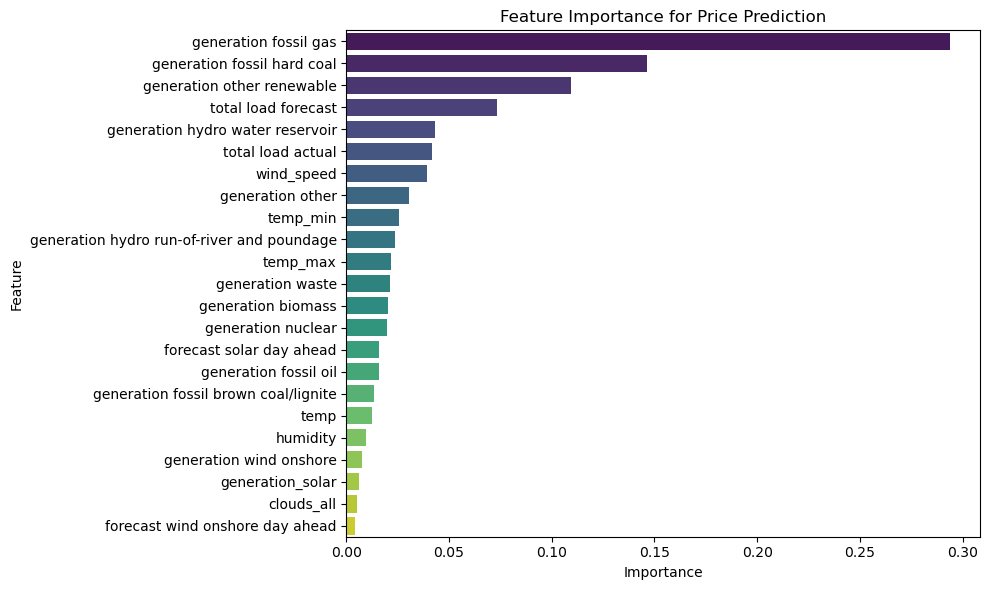

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define your target and features
dependent_variable = 'price actual'
independent_variables = list(set([
    'total load actual', 'temp', 'temp_min', 'temp_max', 'humidity', 
    'generation biomass', 'generation fossil brown coal/lignite',  'generation fossil gas', 
    'generation fossil hard coal', 'generation fossil oil', 
    'generation hydro run-of-river and poundage', 
    'generation hydro water reservoir', 
    'generation nuclear', 'generation other', 'generation other renewable', 
    'generation_solar', 'generation waste',  
    'generation wind onshore', 'forecast solar day ahead', 
    'forecast wind onshore day ahead', 'total load forecast',  'wind_speed', 'clouds_all'
]))

# Selecting relevant columns and dropping rows with NaN
data_for_analysis = merged_data[independent_variables + [dependent_variable]].dropna()

# Split the data into training and testing sets
X = data_for_analysis[independent_variables]
y = data_for_analysis[dependent_variable]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# Get feature importances from the model
feature_importances = model.feature_importances_

# Create a DataFrame for the features and their importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance for Price Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

# Show plot
plt.show()


# Predicted Price Demand Over Time - plot

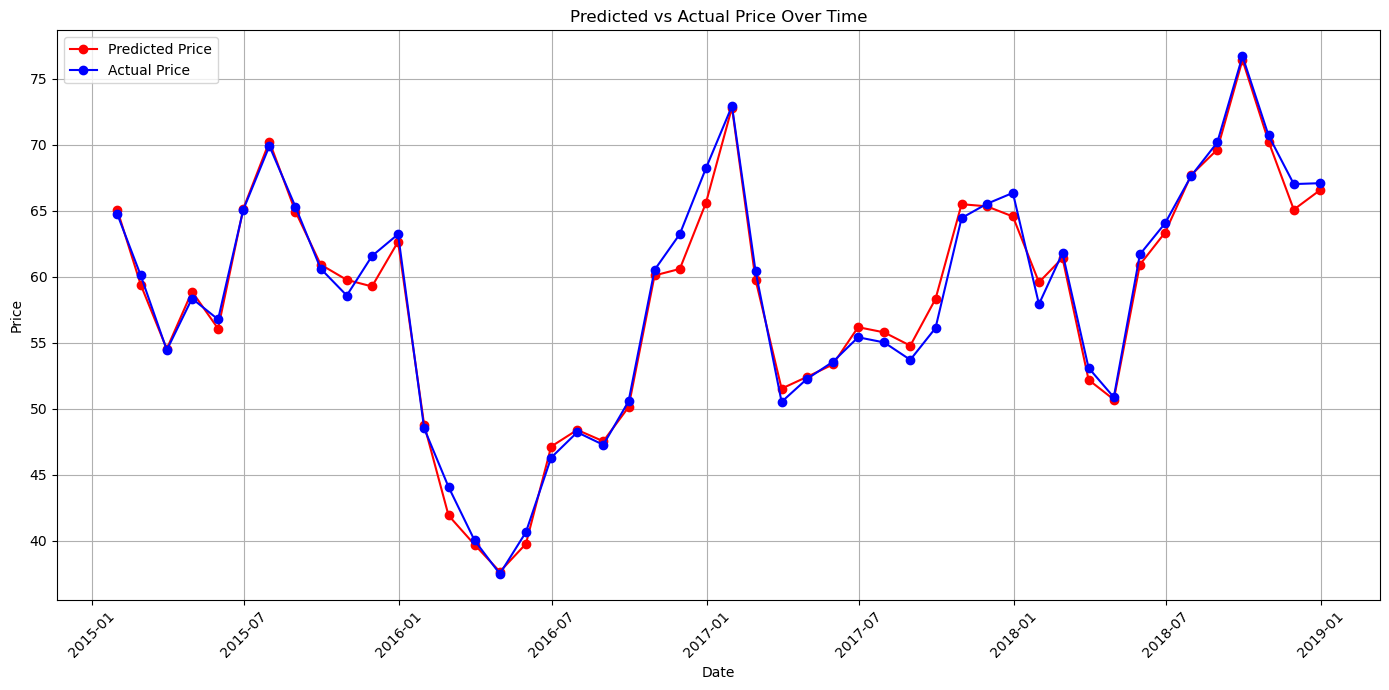

In [53]:
import matplotlib.pyplot as plt

# Create a DataFrame to hold the actual and predicted prices for the test set
results_df = pd.DataFrame({
    'dt_iso': merged_data['dt_iso'].iloc[y_test_price.index],  # Use the correct indices for dates
    'price_predicted': y_test_price_pred,
    'price_actual': y_test_price
})
results_df.set_index('dt_iso', inplace=True)

# Resample the data monthly and calculate the mean
results_monthly = results_df.resample('M').mean()

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(results_monthly.index, results_monthly['price_predicted'], 'r-o', label='Predicted Price')
plt.plot(results_monthly.index, results_monthly['price_actual'], 'b-o', label='Actual Price')

# Formatting the plot
plt.title('Predicted vs Actual Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


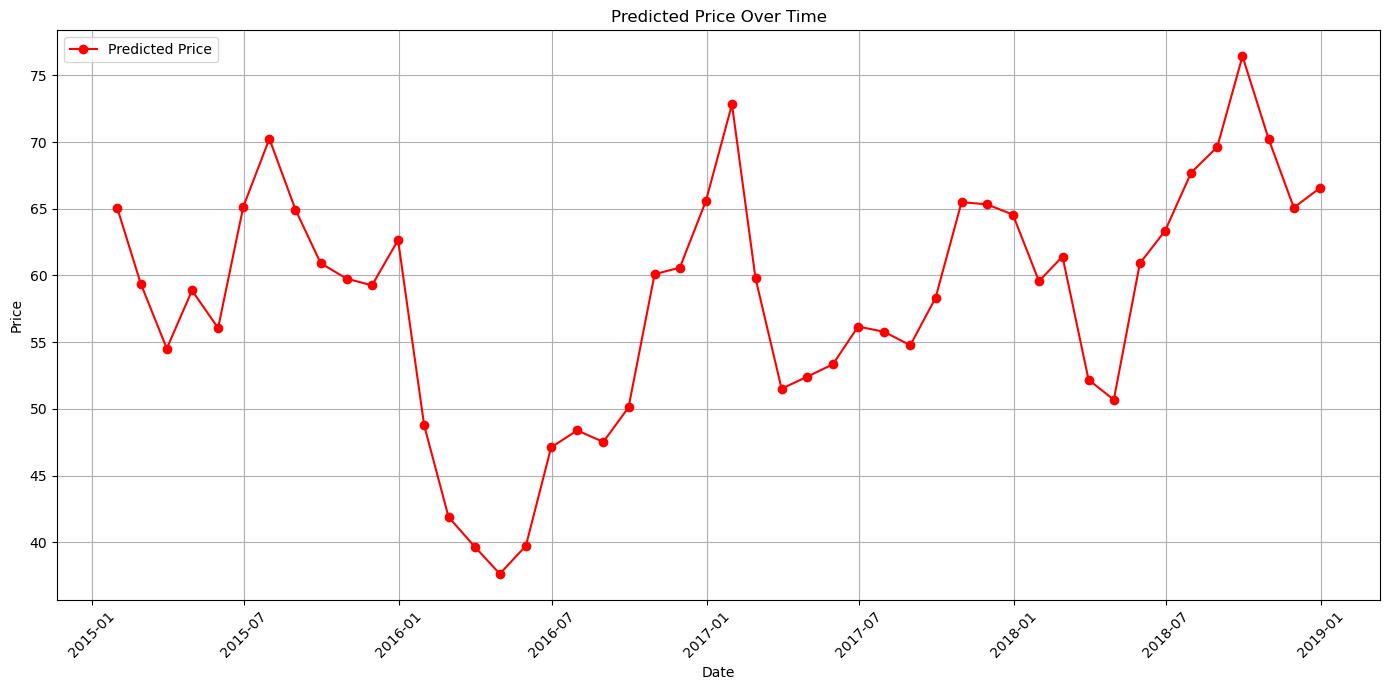

In [54]:
import matplotlib.pyplot as plt

# Create a DataFrame to hold the predicted prices for the test set
results_df = pd.DataFrame({
    'dt_iso': merged_data['dt_iso'].iloc[y_test_price.index],  # Use the correct indices for dates
    'price_predicted': y_test_price_pred
})
results_df.set_index('dt_iso', inplace=True)

# Resample the data monthly and calculate the mean
results_monthly = results_df.resample('M').mean()

# Plotting the predicted prices
plt.figure(figsize=(14, 7))
plt.plot(results_monthly.index, results_monthly['price_predicted'], 'r-o', label='Predicted Price')

# Formatting the plot
plt.title('Predicted Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


#  Predicted LoadDemand Over Time - plot

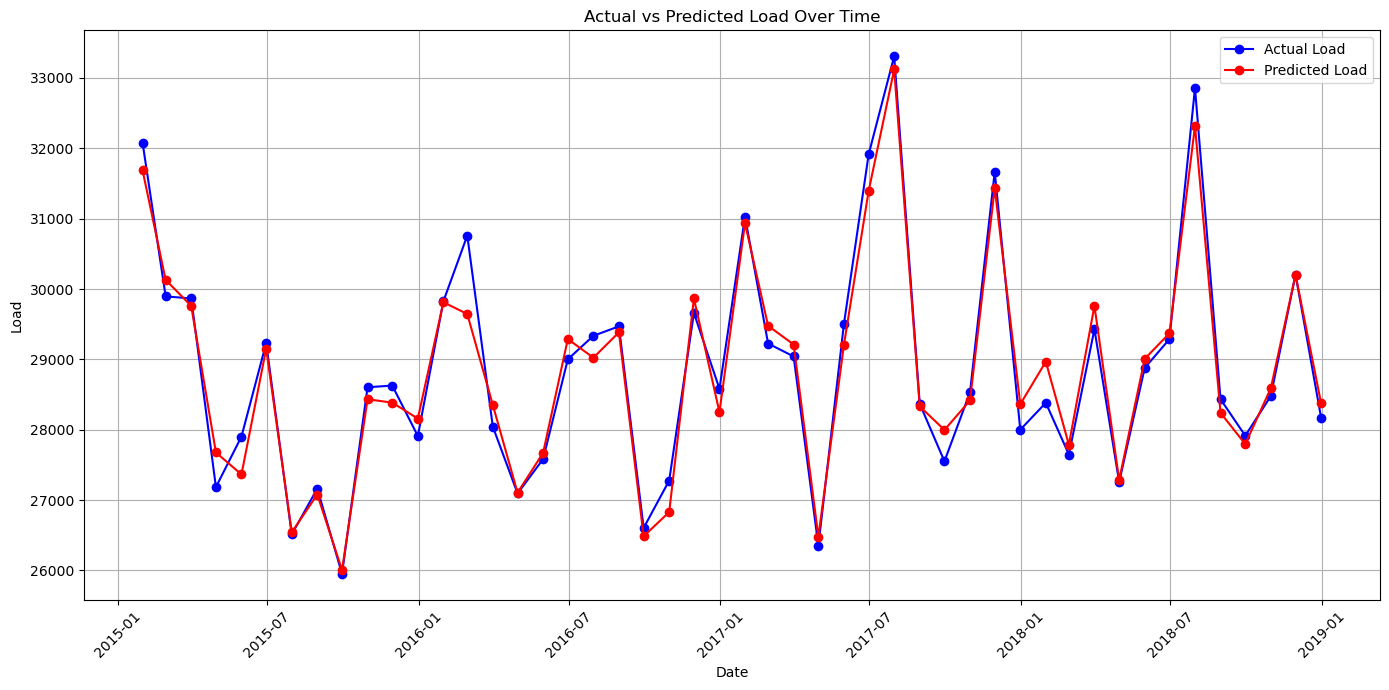

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'merged_data' is your original DataFrame and 'X_test_load_gbt' is your test set features
test_indices = X_test_load_gbt.index  # Get indices of the test set

# Extract datetime values from the original DataFrame
dt_values = merged_data.loc[test_indices, 'dt_iso']  # Ensure 'dt_iso' is the correct datetime column

# Create a DataFrame for actual and predicted load values
load_results_df = pd.DataFrame({
    'dt_iso': dt_values,          # Use the extracted datetime values
    'load_actual': y_test_load_gbt,
    'load_predicted': y_pred_load_gbt
})

# Set the datetime column as the index
load_results_df.set_index('dt_iso', inplace=True)

# Resample the data to monthly frequency
load_results_monthly = load_results_df.resample('M').mean()

# Plotting actual and predicted load
plt.figure(figsize=(14, 7))
plt.plot(load_results_monthly.index, load_results_monthly['load_actual'], 'b-o', label='Actual Load')
plt.plot(load_results_monthly.index, load_results_monthly['load_predicted'], 'r-o', label='Predicted Load')

# Formatting the plot
plt.title('Actual vs Predicted Load Over Time')
plt.xlabel('Date')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


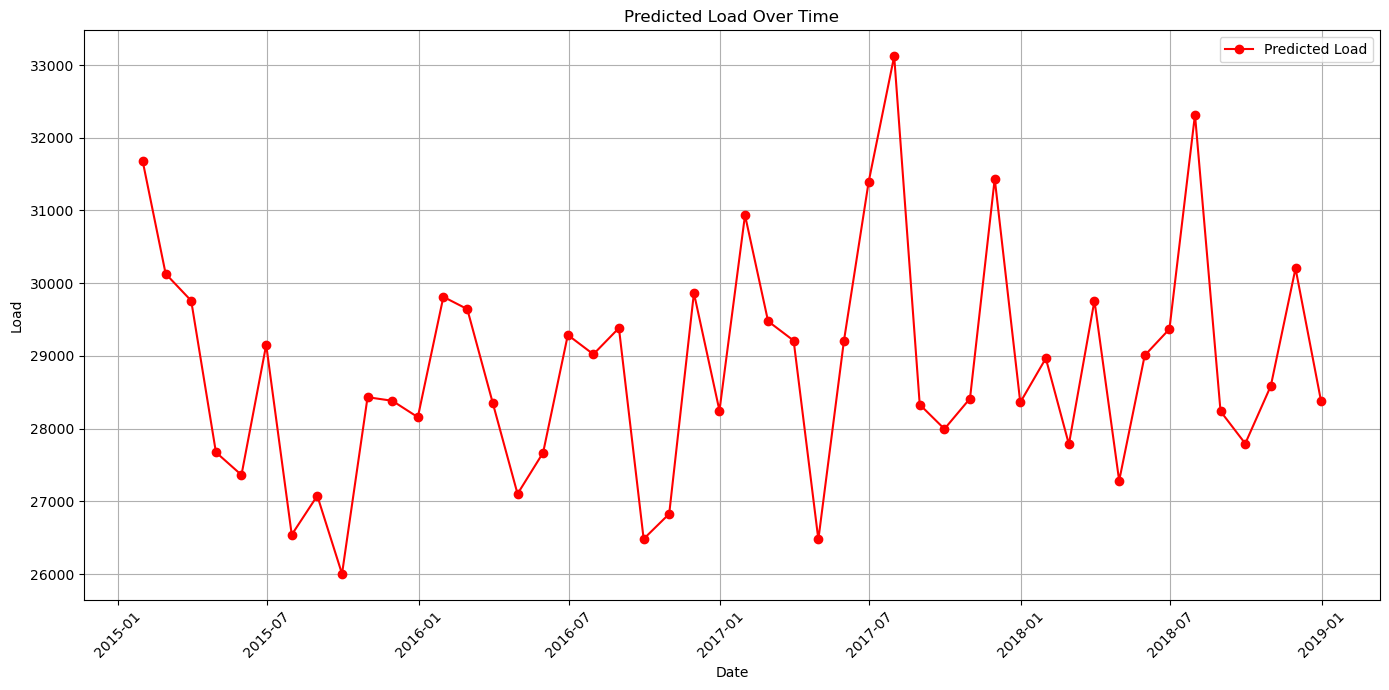

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'merged_data' is your original DataFrame and 'X_test_load_gbt' is your test set features
test_indices = X_test_load_gbt.index  # Get indices of the test set

# Extract datetime values from the original DataFrame
dt_values = merged_data.loc[test_indices, 'dt_iso']  # Make sure 'dt_iso' is the correct datetime column

# Create a DataFrame for actual and predicted load values
load_results_df = pd.DataFrame({
    'dt_iso': dt_values,          # Use the extracted datetime values
    'load_actual': y_test_load_gbt,
    'load_predicted': y_pred_load_gbt
})

# Set the datetime column as the index
load_results_df.set_index('dt_iso', inplace=True)

# Resample the data to monthly frequency
load_results_monthly = load_results_df.resample('M').mean()

# Plotting the predicted load
plt.figure(figsize=(14, 7))
plt.plot(load_results_monthly.index, load_results_monthly['load_predicted'], 'r-o', label='Predicted Load')

# Formatting the plot
plt.title('Predicted Load Over Time')
plt.xlabel('Date')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()
